In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import data_preprocessing as dp
import utilities
import models.training as train
from models.autoencoder import ConvolutionalAutoencoder

### Create Dataset to train the Autoencoder

```python
data, events = dp.load_data()
# filter out data and events correponding to the inner speech condition
data, events = dp.choose_condition(data, events, 'inner speech')
data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?
norm_data = dp.normalization(data)

autoencoder_dataset = tf.data.Dataset.from_tensor_slices((norm_data, norm_data))
autoencoder_dataset = dp.preprocessing_pipeline(
    autoencoder_dataset,
    functions = [dp.filter_interval_tensor,
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 tf.reshape(sample[0], (128, 640, 1)))
                ],
    args = [[[1, 3.5], 256, [0, 1]], []],
    batch_size = 12
)

# save dataset so that we can just load the preprocessed version next time
tf.data.experimental.save(autoencoder_dataset, 'dataset/preprocessed/autoencoder_ds')
```

In [3]:
# load dataset
dataset = tf.data.experimental.load('dataset/preprocessed/autoencoder_ds')

autoencoder_datasets = dp.split_dataset(dataset,
                                        splits={'train':0.9,
                                                'test':0.05,
                                                'valid':0.05})

2022-03-07 13:57:52.456521: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2123      
                                                                 
 decoder (Decoder)           multiple                  4001      
                                                                 
Total params: 6,124
Trainable params: 6,124
Non-trainable params: 0
_________________________________________________________________


2022-03-07 13:58:00.999402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


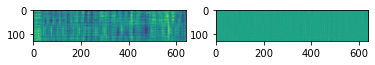

In [4]:
autoencoder = ConvolutionalAutoencoder()
autoencoder.build((None, 128,640,1))

autoencoder.summary()

for _input, target in autoencoder_datasets['train'].take(1):
    out = autoencoder(_input)
    plt.subplot(1,2,1)
    plt.imshow(target[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(out[0][:,:,0])

In [5]:
%matplotlib tk
# Initialize the loss-function
loss_func = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(autoencoder, autoencoder_datasets, optimizer, loss_func)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(2,1, supxlabel='Epochs', axs_xlabels=[['train loss', 'test loss']])

for epoch in range(30):
    print(epoch, end='\r')  
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test']])


2022-03-07 13:58:19.680744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-07 13:58:19.755845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/lld/Documents/inner_speech_decoding/utilities.py:75: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.axs[i%self.plot_shape[1], i//self.plot_shape[1]].set_xlim(min(xd), max(xd))


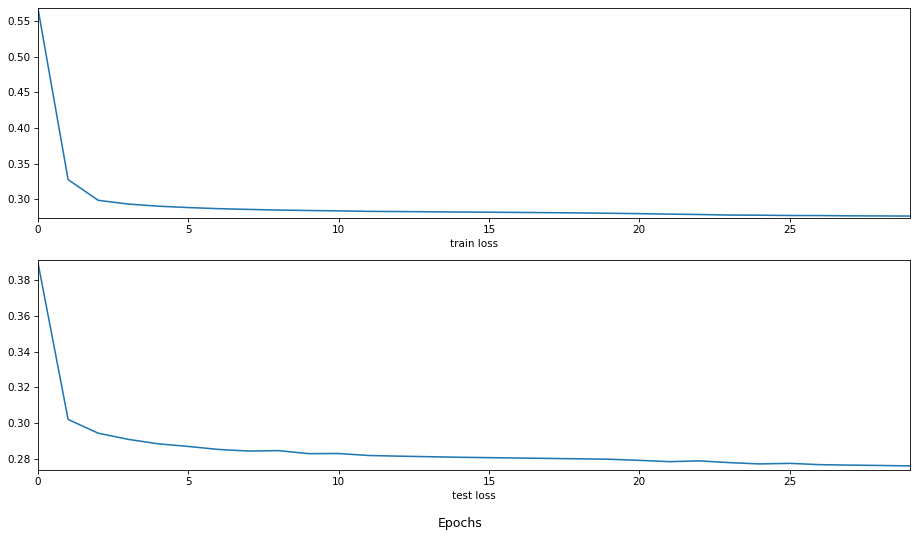

In [7]:
%matplotlib inline
grapher.fig.set_size_inches(15, 8)
grapher.fig

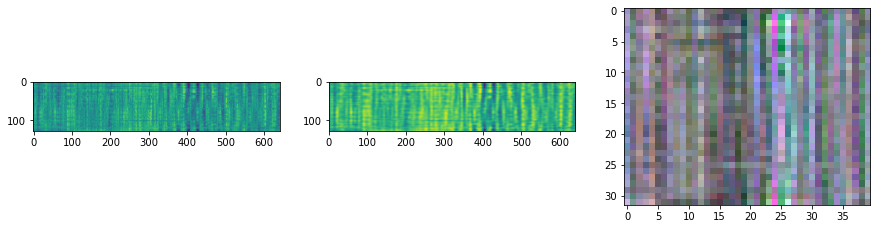

In [17]:
for i, t in autoencoder_datasets['valid'].take(1):
    out_enc = autoencoder.encoder(i)
    out_dec = autoencoder.decoder(out_enc)
    f, axs = plt.subplots(1,3,figsize=(15,15))
    axs[0].imshow(t[0][:,:,0])
    axs[1].imshow(out_dec[0][:,:,0])
    # normalize each channel
    norm_enc = out_enc[0] / np.max(out_enc[0], (0, 1))[np.newaxis, np.newaxis, :]
    axs[2].imshow(norm_enc)

In [18]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
autoencoder.save('./models/saved_models/autoencoder_30Epochs')

2022-03-07 14:04:49.388937: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/saved_models/autoencoder_30Epochs/assets
